[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U6O7m-uKP97PadD8HHEXbmv1kRAgqQtE?usp=sharing)

# Projeto - Ambiente Breakout


## Configurações Iniciais

Instalação de pacotes e atribuição do caminho para o código do projeto

In [41]:
import pygame # this import here is just to prevent a strange bug (with some dynamic library used by pygame and other packages)

import sys
from IPython.display import clear_output

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install opencv-python
    !pip install swig
    !pip install gymnasium[all]   # 0.28.1
    !pip install gymnasium[atari,accept-rom-license]
    !pip install "stable-baselines3[extra]==2.1.0"
    !pip install gymnasium[box2d]   # works with gymnasium version 0.28.1
    !pip install tensorboard

    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

Import de pacotes necessários

In [42]:
import time
from datetime import datetime
import collections
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
import tensorboard

import stable_baselines3
stable_baselines3.__version__

import matplotlib.pyplot as plt

import gymnasium as gym

Import de algumas funções a serem utilizadas no DQN e para gerar o vídeo

In [43]:
from utils import dqn_models
from utils.atari_wrappers import *

from utils.notebook import display_videos_from_path, display_videos_from_path_widgets, display_video

In [44]:
# usar GPU compatível com CUDA costuma ser mais rápido
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_default_device(device)

Import de algumas funções que serão utilizadas no PPO

In [45]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# para treinar com ambientes Atari
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.ppo import CnnPolicy

Carrega a extensão para visualizar o `tensorboard`

In [46]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Funções para gerar gráficos

Gráfico de resultados individuais, com desvio padrão e distribuição normal

In [47]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

def extract_scalar_from_event(file_path, scalar_name):
    event_acc = EventAccumulator(file_path, size_guidance={'scalar': 0})
    event_acc.Reload()

    steps = [scalar.step for scalar in event_acc.Scalars(scalar_name)]
    values = [scalar.value for scalar in event_acc.Scalars(scalar_name)]

    return steps, values

def get_last_values(folder_path, scalar_name='rollout/ep_rew_mean'):
    last_values = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("events"):  
            file_path = os.path.join(folder_path, file_name)
            steps, values = extract_scalar_from_event(file_path, scalar_name)
            if values:
                last_values.append(values[-1])

    return last_values

def plot_distribution_of_last_values(log_directory, scalar_name='rollout/ep_rew_mean'):
    last_values = []

    for subdirectory in os.listdir(log_directory):
        subdirectory_path = os.path.join(log_directory, subdirectory)
        if os.path.isdir(subdirectory_path):
            last_values.extend(get_last_values(subdirectory_path, scalar_name))

    # Plotando a distribuição normal para os últimos valores de cada arquivo
    plt.figure(figsize=(16, 9))
    sns.histplot(last_values, kde=True, label='Distribution', stat='density')
    plt.title(f'Distribution of Last {scalar_name} Values for All Files')
    plt.xlabel(f'Last {scalar_name} Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def process_folder(folder_path, scalar_name='rollout/ep_rew_mean'):
    all_steps = []
    all_values = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("events"):  
            file_path = os.path.join(folder_path, file_name)
            steps, values = extract_scalar_from_event(file_path, scalar_name)
            all_steps.append(steps)
            all_values.append(values)

    return all_steps, all_values

def process_folder_individual(folder_path, scalar_name='rollout/ep_rew_mean'):
    all_steps = []
    all_values = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("events"):  # Certifique-se de que é um arquivo de eventos TensorBoard
            file_path = os.path.join(folder_path, file_name)
            steps, values = extract_scalar_from_event(file_path, scalar_name)
            all_steps.extend(steps)
            all_values.extend(values)

    return all_steps, all_values

def plot_individual(log_directories, scalar_name='rollout/ep_rew_mean'):
    plt.figure(figsize=(16,9))
    for log_directory in log_directories:
        for subdirectory in os.listdir(log_directory):
            subdirectory_path = os.path.join(log_directory, subdirectory)
            if os.path.isdir(subdirectory_path):
                steps, values = process_folder_individual(subdirectory_path, scalar_name)
                
                # Plotando os resultados individuais
                plt.plot(steps, values, label=f'{subdirectory}')

    plt.xlabel('Steps')
    plt.ylabel(f'Reward')
    plt.legend()
    plt.title(f'Reward x Step')
    plt.show()

def plot_individual_and_mean_with_std_and_distribution(log_directory, scalar_name='rollout/ep_rew_mean'):
    all_steps = []
    all_values = []

    # Plotando as linhas individuais e calculando a média e desvio padrão
    for subdirectory in os.listdir(log_directory):
        subdirectory_path = os.path.join(log_directory, subdirectory)
        if os.path.isdir(subdirectory_path):
            steps, values = process_folder(subdirectory_path, scalar_name)

            all_steps.extend(steps)
            all_values.extend(values)

    flat_all_steps = [item for sublist in all_steps for item in sublist]
    flat_all_values = [item for sublist in all_values for item in sublist]

    unique_steps = sorted(set(flat_all_steps))
    interp_values = []
    
    for steps, values in zip(all_steps, all_values):
        interp_func = interp1d(steps, values, kind='linear', fill_value='extrapolate')
        interp_values.append(interp_func(unique_steps))

    mean_values = np.mean(interp_values, axis=0)
    std_values = np.std(interp_values, axis=0)

    # Plotando a média e desvio padrão
    plt.figure(figsize=(16, 9))
    for subdirectory, (sub_steps, sub_values) in zip(os.listdir(log_directory), zip(all_steps, all_values)):
        plt.plot(sub_steps, sub_values, label=f'{subdirectory}', alpha=0.75)

    plt.plot(unique_steps, mean_values, 'k--', label=f'Média')
    plt.fill_between(unique_steps, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.4, label=f'Desvio padrão')

    plt.xlabel('Steps')
    plt.ylabel(f'Value')
    plt.legend()
    plt.title(f'Reward x Step com desvio padrão')

## DQN - Definições Auxiliares

Classes Auxiliares

In [48]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class DQNExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, s1, a, r, done, s2):
        experience = Experience(s1, a, r, done, s2)
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

Funções Auxiliares

In [49]:
# Faz uma escolha epsilon-greedy
def choose_action(qnet, env, state, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a, dtype=torch.float32)
        q_vals_v = qnet(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())

# Se a ação aleatória escolhida for 1 (FIRE) ela é definida como 0 para que otimize o algoritmo e apenas reservar a ação 1 para resetar o ambiente / resetar as bolas
    # if action == 1:
    #     action = 0
        
    return action

In [50]:
# loss function, para treinamento da rede no DQN
def calc_loss(batch, net, tgt_net, gamma):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states, dtype=torch.float32)
    next_states_v = torch.tensor(next_states, dtype=torch.float32)
    actions_v = torch.tensor(actions, dtype=torch.int64)
    rewards_v = torch.tensor(rewards)
    done_mask = torch.tensor(dones, dtype=torch.bool)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(dim=1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    target_state_action_values = rewards_v + gamma * next_state_values
    return nn.MSELoss()(state_action_values, target_state_action_values)

In [51]:
def record_video_q_neuralnet(env_name, qnet, episodes=3, folder='videos/', prefix='rl-video', epsilon=0.0):
    """
    Grava um vídeo a partir de uma política epsilon-greedy definida pela 'qtable' e pelo valor de 'epsilon'.
    - env_name: A string do ambiente cadastrada no gymnasium ou uma instância da classe. Ao final, o ambiente é fechado (função `close()`).
    - qnet: A rede neural que representa a função Q.
    - episodes: Número de episódios completos que serão executados.
    - prefiz: Prefixo do nome dos arquivos de vídeo.
    - folder: Pasta onde os arquivos de vídeo serão salvos.
    - epsilon: Valor do parâmetro da política "epsilon-greedy" usada para escolher as ações.
    """
    if isinstance(env_name, str):
        env = gym.make(env_name, render_mode="rgb_array")
    else:
        env = env_name
    rec_env = gym.wrappers.RecordVideo(env, folder, episode_trigger=lambda i : True, name_prefix=prefix)
    num_steps = 0
    last_episodes_rewards = []
    for epi in range(episodes):
        state, _ = rec_env.reset()
        num_steps += 1
        epi_reward = 0.0
        done = False
        while not done:
            action = choose_action(qnet, env, state, epsilon)

            #lógica para resetar o ambiente
            if np.mean(last_episodes_rewards[-30:]) == 0 and len(last_episodes_rewards) > 30:
                last_episodes_rewards.clear()
                action = 1
            state, r, termi, trunc, _ = rec_env.step(action)
            done = termi or trunc
            num_steps += 1
            epi_reward += r
            last_episodes_rewards.append(r)
        print(f"Episode {epi}: {num_steps} steps / return {epi_reward:.2f}")
    rec_env.close()
    env.close()

Função principal

In [52]:
def DQN_TRAIN(env, env_name, gamma, qnet, qnet_lr, target_qnet, target_update_freq, replay_size, batch_size, epsilon_f, epsilon_decay_period, GOAL_REWARD,STEPS_STOP):
    print(qnet)

    # Cria o otimizador, que vai fazer o ajuste dos pesos da 'qnet',
    # Usa uma técnica de gradiente descendente de destaque, chamada ADAM
    optimizer = optim.Adam(qnet.parameters(), lr=qnet_lr)

    # Para o logging de dados, para serem exibidos no tensorboard
    writer = SummaryWriter(comment="-" + 'DQN')

    buffer = DQNExperienceBuffer(replay_size)

    start_time_str = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
    episode_reward_list = []
    step = 0
    epsilon = 1.0

    state, _ = env.reset()
    episode_reward = 0.0
    episode_start_step = 0
    episode_start_time = time.time()
    last_episodes_rewards = []

    while True:
        step += 1

        # Decaimento linear do epsilon
        epsilon = max(epsilon_f, 1.0 - step / epsilon_decay_period)

        action = choose_action(qnet, env, state, epsilon)

        # last_episodes_rewards armazena o histórico de recompensas de cada episódio
        # Caso a média das últimas 30 recompensas seja = 0 e o array tenha o histórico de pelo menos 30 recompensas
        # É definida por padrão a ação 1 (FIRE), pois a cada vida perdida (BOLA) o jogador precisa apertar o botão FIRE para continuar o jogo com uma nova bola
        # Com valores epsilon altos, a chance de continuar o jogo é alta, mas com o epsilon baixo a ação 1 é quase nunca escolhida, travando o ambiente
        # Após isso o last_episodes_rewards é limpo
        # if np.mean(last_episodes_rewards[-30:]) == 0 and len(last_episodes_rewards) > 30:
        #     last_episodes_rewards.clear()
        #     action = 1

        # Faz um passo / Aplica uma ação no ambiente
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        last_episodes_rewards.append(reward)

        # Adiciona no buffer
        buffer.append(state, action, reward, terminated, new_state)
        state = new_state

        if done:
            last_episodes_rewards.clear()
            episode_reward_list.append(episode_reward)
            speed = (step - episode_start_step) / (time.time() - episode_start_time + 0.00001)

            state, _ = env.reset()
            episode_start_step = step
            episode_start_time = time.time()

            # Abaixo, faz vários loggings de dados
            mean_reward = np.mean(episode_reward_list[-100:])
            print(f"{step}: finished {len(episode_reward_list)} episodes, last reward {episode_reward_list[-1]}, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} steps/s")
            writer.add_scalar("DQN/epsilon", epsilon, step)
            writer.add_scalar("DQN/epi_reward", episode_reward, step)
            writer.add_scalar("DQN/ep_reward_100", mean_reward, step)
            writer.add_scalar("rollout/ep_rew_mean", mean_reward, step)
            
            episode_reward = 0.0

            # Testa se atingiu os valores alvos de recompensa ou passos no ambiente
            if mean_reward > GOAL_REWARD or step > STEPS_STOP:
                print(f"Solved in {step} steps with mean reward {mean_reward:.3f}")
                filename = env_name + "-" + start_time_str + ".dat"
                torch.save(qnet.state_dict(), filename)
                print(f"Model saved as {filename}")
                break

        if len(buffer) < replay_size:
            continue

        # Faz a 'tgt_net' receber os mesmos valores de pesos da 'qnet', na frequência indicada
        if step % target_update_freq == 0:
            target_qnet.load_state_dict(qnet.state_dict())

        if step % 10000 == 0:
            clear_output()

        # Escolhendo amostras aleatórios do buffer e faz uma atualização dos pesos da rede
        optimizer.zero_grad()
        batch = buffer.sample(batch_size)
        loss_t = calc_loss(batch, qnet, target_qnet, gamma)
        loss_t.backward()
        optimizer.step()

    writer.close()

## DQN - Treinamento + Resultados

In [53]:
ATARI_ENV_NAME = "BreakoutNoFrameskip-v4"

GOAL_REWARD = 1000
STEPS_STOP = 1_000_000

# Parâmetros do DQN
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 20_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 2_048

EPSILON_DECAY_PERIOD = 400_000
EPSILON_FINAL = 0.02

env2 = gym.make(ATARI_ENV_NAME)

In [54]:
# Aplica os wrappers do DQN para ambientes Atari
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

# Cria as redes neurais
qnet2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)
qtarget2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)

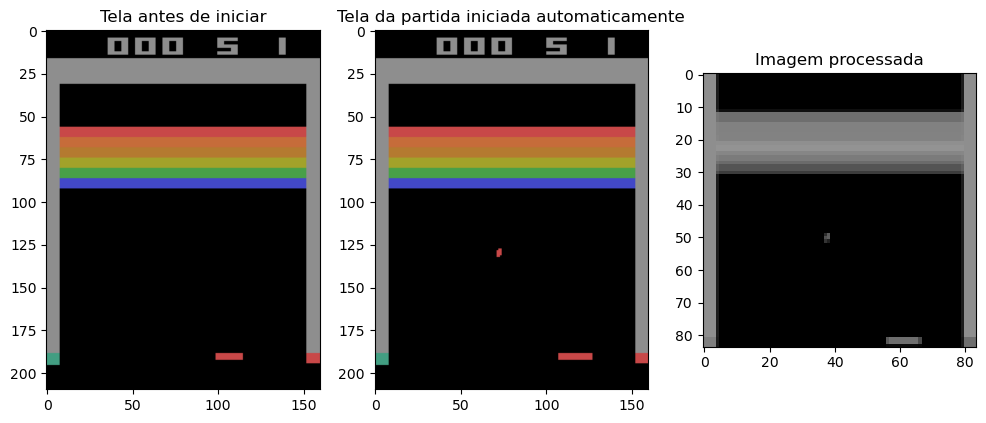

In [55]:
# Mostrando a tela do ambiente original, e outras telas após passar por alguns wrappers
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

s, _ = env2.reset()
ax1.imshow(s)
ax1.set_title('Tela antes de iniciar')

s, _ = env2b.reset()
ax2.imshow(s)
ax2.set_title('Tela da partida iniciada automaticamente')

s, _ = env2d.reset()
ax3.imshow(s[0], cmap='gray', vmin=0, vmax=255)  # exibe em escala de cinza
ax3.set_title('Imagem processada');

In [18]:
# Para treinar o agente, rode o código abaixo
DQN_TRAIN(
    env = env2f,
    env_name = ATARI_ENV_NAME,
    gamma = GAMMA,
    qnet = qnet2,
    qnet_lr = LEARNING_RATE,
    target_qnet = qtarget2,
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE,
    batch_size = BATCH_SIZE,
    epsilon_f = EPSILON_FINAL,
    epsilon_decay_period = EPSILON_DECAY_PERIOD,
    GOAL_REWARD = GOAL_REWARD,
    STEPS_STOP = STEPS_STOP)

1000059: finished 2584 episodes, last reward 17.0, mean reward 24.960, eps 0.02, speed 16.21 steps/s
Solved in 1000059 steps with mean reward 24.960
Model saved as BreakoutNoFrameskip-v4-2024-02-11,22-41-42.dat


In [28]:
# Para carregar uma rede salva de arquivo, descomente o bloco abaixo
# Permite testar ou treinar mais
# filename = "/content/rl_facil/projeto/" if IN_COLAB else ""
# filename = filename + "BreakoutNoFrameskip-v4-2024-02-11,22-41-42.dat"
# qnet2.load_state_dict(torch.load(filename, map_location=lambda storage,loc: storage))

<All keys matched successfully>

In [33]:
# Roda alguns episódios com o modelo e salva os vídeos em arquivos
env2 = gym.make(ATARI_ENV_NAME, render_mode="rgb_array")
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

record_video_q_neuralnet(env2f, qnet2, episodes=1, folder="./dqn-breakout")

Moviepy - Building video d:\Projects\rl_facil\projeto\dqn-breakout\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Projects\rl_facil\projeto\dqn-breakout\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Projects\rl_facil\projeto\dqn-breakout\rl-video-episode-0.mp4
Episode 0: 438 steps / return 34.00


In [8]:
display_videos_from_path('./dqn-breakout')

## PPO - Função principal

In [56]:
ENV_NAME = 'BreakoutNoFrameskip-v4' #'ALE/Pong-v5' 

# Esta função cria o ambiente, junto com wrappers especializados
env = make_atari_env(ENV_NAME, n_envs=4, seed=0)

# Wrapper para fazer cada estado ser uma "pilha" de 4 frames
env = VecFrameStack(env, n_stack=4)

# Cria com uma rede convolucional como política
model = PPO(CnnPolicy, env, tensorboard_log="log_dir", verbose=1)

Using cpu device
Wrapping the env in a VecTransposeImage.


## PPO - Otimização de parâmetros + Treinamento

Otimização de 200 mil passos com as 27 possibilidades de parâmetros, alternando entre 3 valores de learning_rate, batch_size e n_steps

In [ ]:
model1 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=64,n_steps=2048)
model1.learn(total_timesteps=200_000)

In [ ]:
model2 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=32,n_steps=2048)
model2.learn(total_timesteps=200_000)

In [ ]:
model3 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=128,n_steps=2048)
model3.learn(total_timesteps=200_000)

In [ ]:
model4 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=64,n_steps=1024)
model4.learn(total_timesteps=200_000)

In [ ]:
model5 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=64,n_steps=4096)
model5.learn(total_timesteps=200_000)

In [ ]:
model6 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=32,n_steps=1024)
model6.learn(total_timesteps=200_000)

In [ ]:
model7 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=32,n_steps=4096)
model7.learn(total_timesteps=200_000)

In [ ]:
model8 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=128,n_steps=1024)
model8.learn(total_timesteps=200_000)

In [ ]:
model9 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0003,batch_size=128,n_steps=4096)
model9.learn(total_timesteps=200_000)

In [ ]:
model10 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=64,n_steps=2048)
model10.learn(total_timesteps=200_000)

In [ ]:
model11 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model11.learn(total_timesteps=200_000)

In [ ]:
model12 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=128,n_steps=2048)
model12.learn(total_timesteps=200_000)

In [ ]:
model13 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=64,n_steps=1024)
model13.learn(total_timesteps=200_000)

In [ ]:
model14 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=64,n_steps=4096)
model14.learn(total_timesteps=200_000)

In [ ]:
model15 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=1024)
model15.learn(total_timesteps=200_000)

In [ ]:
model16 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=4096)
model16.learn(total_timesteps=200_000)

In [ ]:
model17 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=128,n_steps=1024)
model17.learn(total_timesteps=200_000)

In [ ]:
model18 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0001,batch_size=128,n_steps=4096)
model18.learn(total_timesteps=200_000)

In [ ]:
model19 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=64,n_steps=2048)
model19.learn(total_timesteps=200_000)

In [ ]:
model20 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=64,n_steps=1024)
model20.learn(total_timesteps=200_000)

In [ ]:
model21 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=64,n_steps=4096)
model21.learn(total_timesteps=200_000)

In [ ]:
model22 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=32,n_steps=2048)
model22.learn(total_timesteps=200_000)

In [ ]:
model23 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=32,n_steps=1024)
model23.learn(total_timesteps=200_000)

In [ ]:
model24 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=32,n_steps=4096)
model24.learn(total_timesteps=200_000)

In [ ]:
model25 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=128,n_steps=2048)
model25.learn(total_timesteps=200_000)

In [ ]:
model26 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=128,n_steps=1024)
model26.learn(total_timesteps=200_000)

In [ ]:
model27 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_1", verbose=1,learning_rate=0.0005,batch_size=128,n_steps=4096)
model27.learn(total_timesteps=200_000)

_______________________________________________________________________________________

Otimização de 400 mil passos com as 6 melhores combinações de parâmetros da primeira otimização

In [ ]:
model2 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_2", verbose=1,learning_rate=0.0003,batch_size=32,n_steps=2048)
model2.learn(total_timesteps=400_000)

In [ ]:
model3 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_2", verbose=1,learning_rate=0.0003,batch_size=128,n_steps=2048)
model3.learn(total_timesteps=400_000)

In [ ]:
model10 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_2", verbose=1,learning_rate=0.0001,batch_size=64,n_steps=2048)
model10.learn(total_timesteps=400_000)

In [ ]:
model11 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_2", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model11.learn(total_timesteps=400_000)

In [ ]:
model19 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_2", verbose=1,learning_rate=0.0005,batch_size=64,n_steps=2048)
model19.learn(total_timesteps=400_000)

In [ ]:
model25 = PPO(CnnPolicy, env, tensorboard_log="otimizacao_fase_2", verbose=1,learning_rate=0.0005,batch_size=128,n_steps=2048)
model25.learn(total_timesteps=400_000)

____________________

Treinamento por 1M de passos com a melhor combinação de parâmetros

In [ ]:
model = PPO(CnnPolicy, env, tensorboard_log="ppo_run", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model.learn(total_timesteps=1_000_000)

In [ ]:
model = PPO(CnnPolicy, env, tensorboard_log="ppo_run", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model.learn(total_timesteps=1_000_000)

In [ ]:
model = PPO(CnnPolicy, env, tensorboard_log="ppo_run", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model.learn(total_timesteps=1_000_000)

## PPO - Resultados

In [ ]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)

print(f"Retorno médio: {mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
# model.learn(total_timesteps=100_000)

In [ ]:
model.save("ppo_model")
# del model  # delete trained model from memory to demonstrate loading

In [ ]:
# model = PPO.load("ppo_model")

In [ ]:
# model.set_env(gym.make(ENV_NAME))
# model.learn(total_timesteps=100_000)

In [ ]:
# # Evaluate the trained agent
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=30)

# print(f"Retorno médio: {mean_reward:.2f} +/- {std_reward:.2f}")

## Gráficos de comparação + Tensorboard

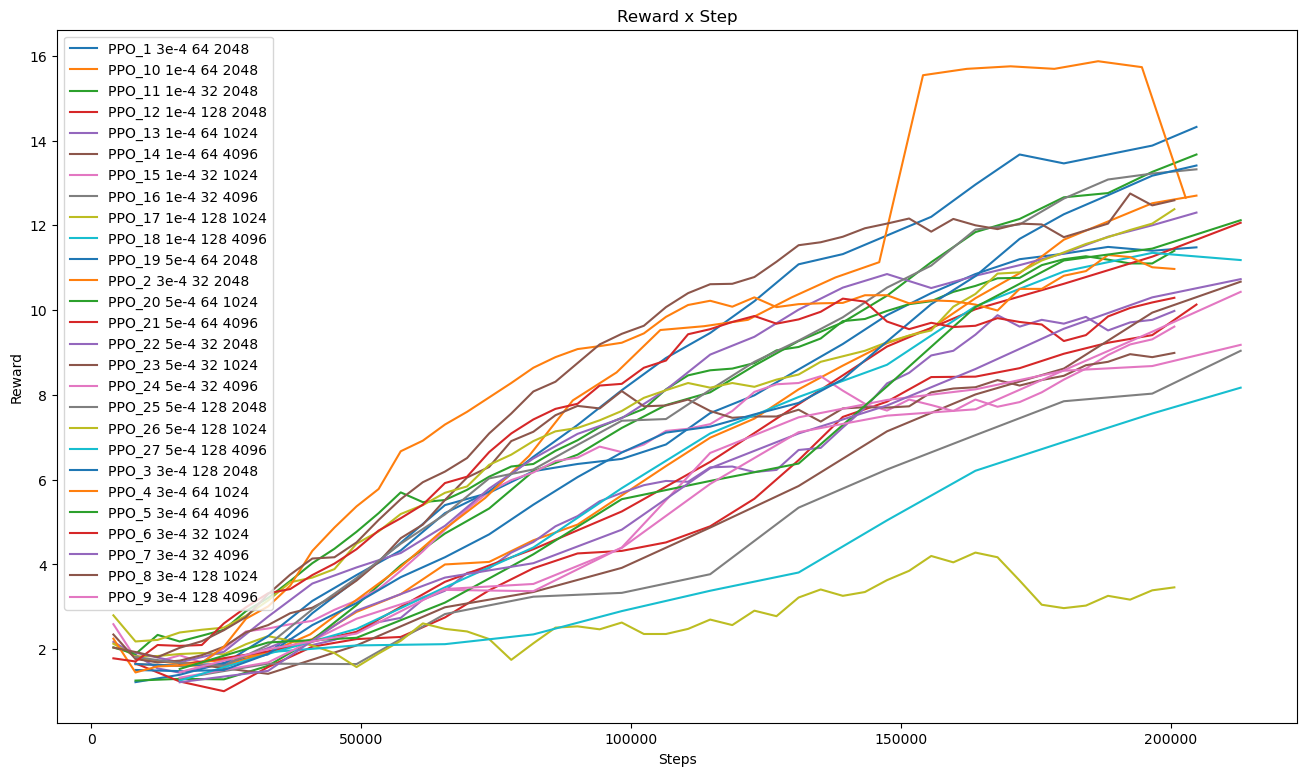

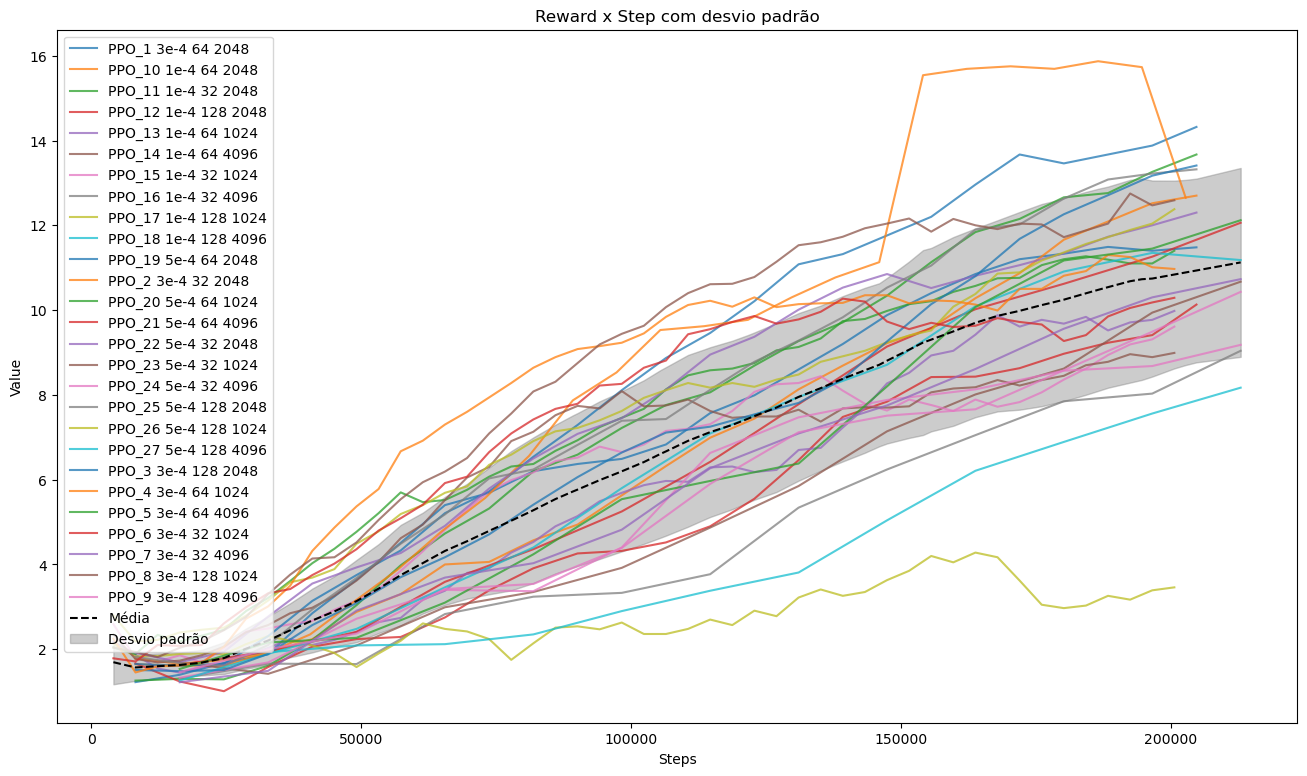

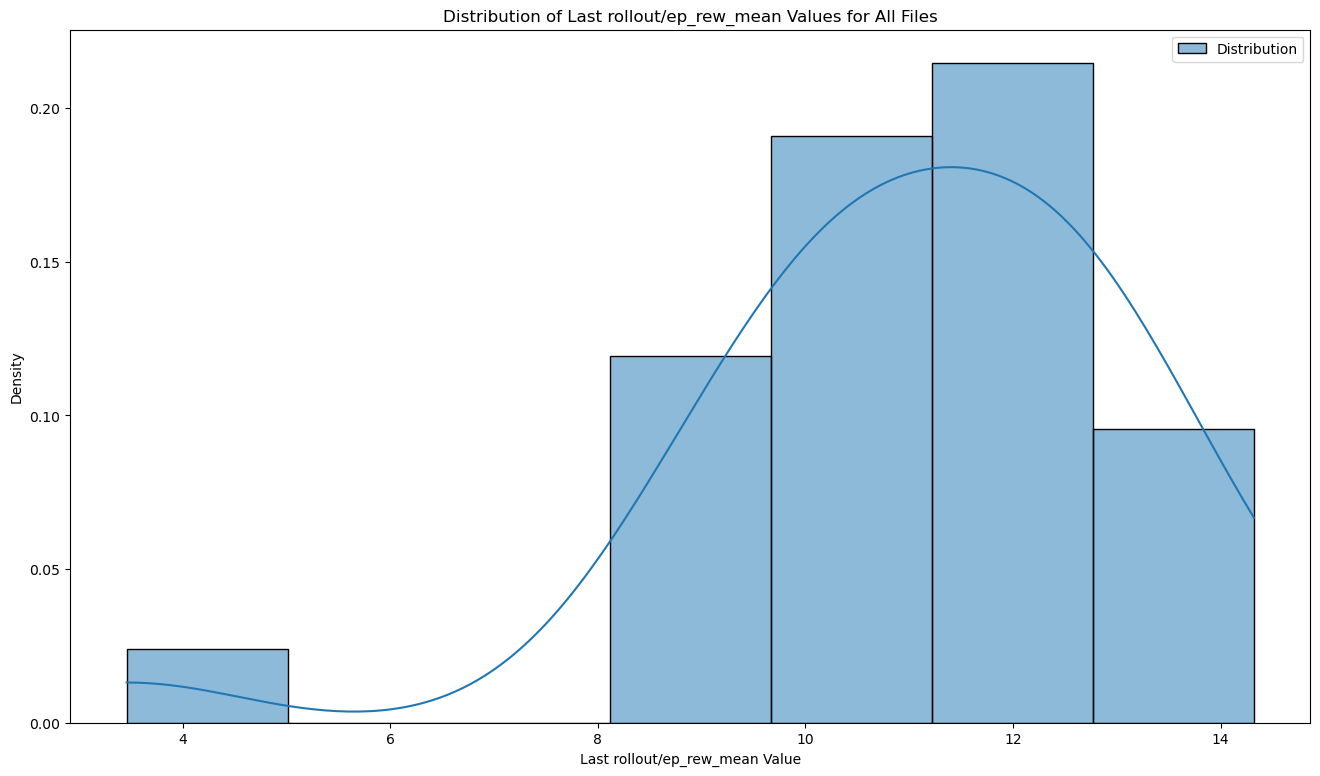

In [37]:
plot_individual(['./otimizacao_fase_1/'])
plot_individual_and_mean_with_std_and_distribution('./otimizacao_fase_1/')
plot_distribution_of_last_values('./otimizacao_fase_1/')

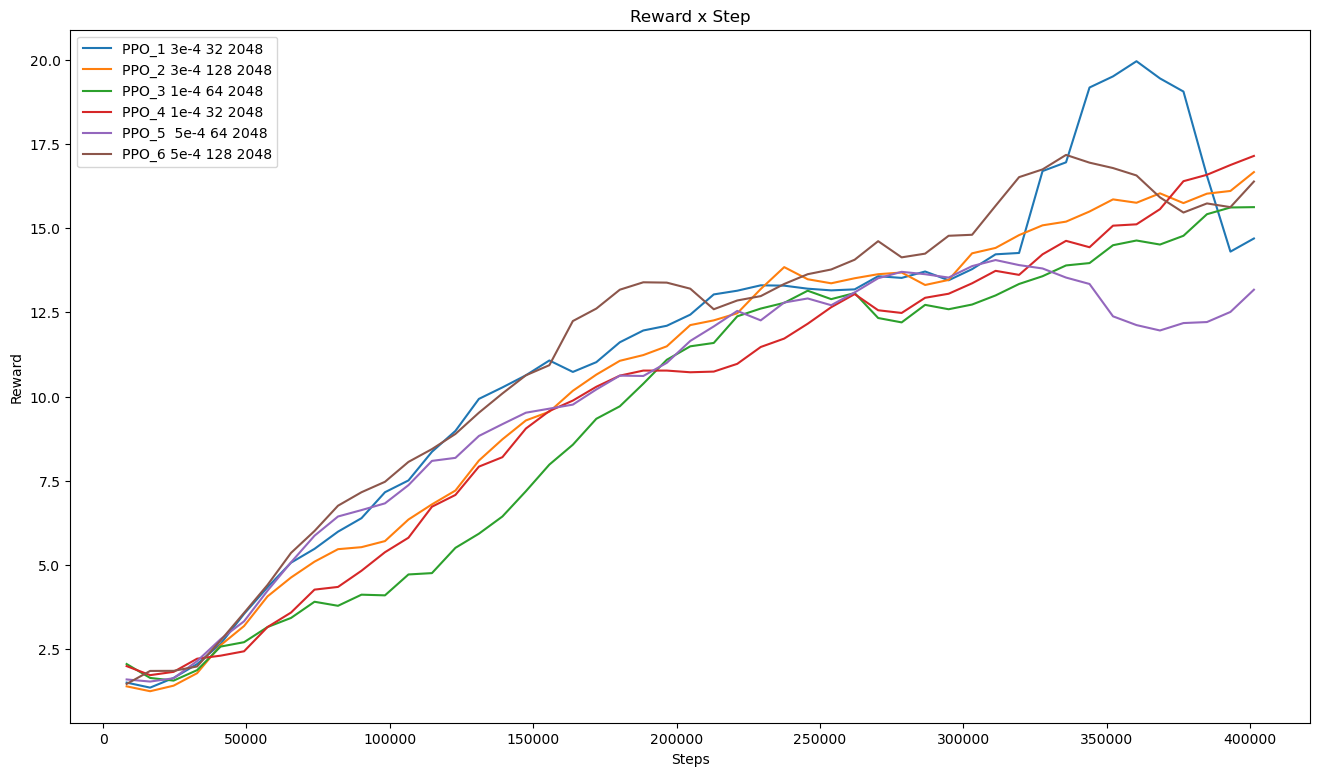

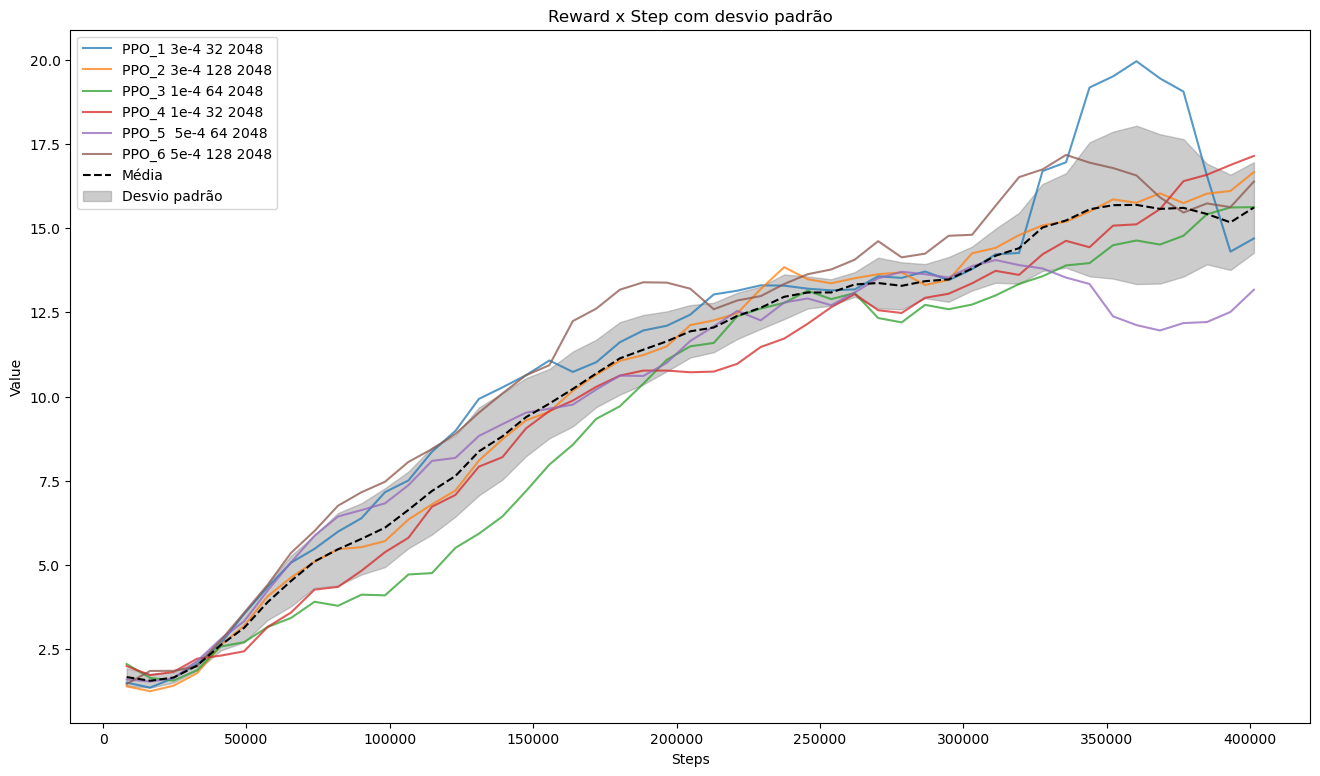

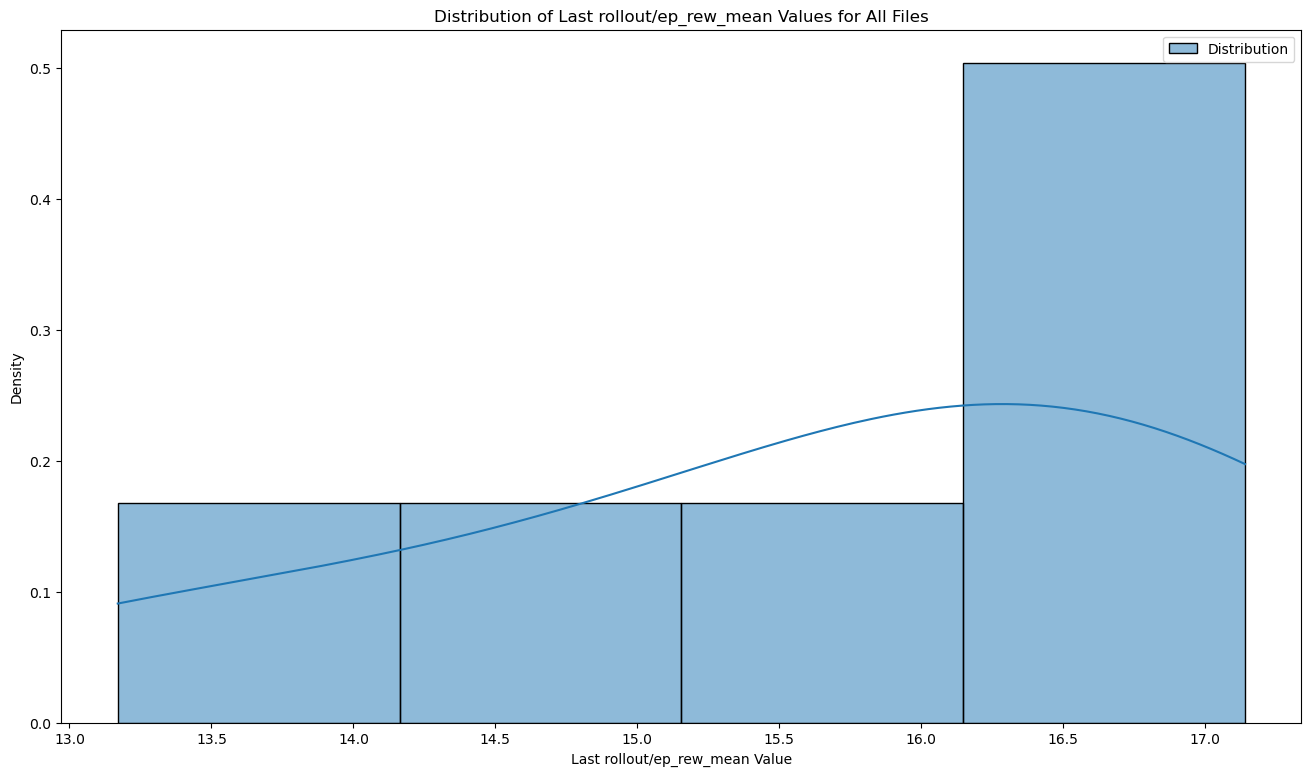

In [38]:
plot_individual(['./otimizacao_fase_2/'])
plot_individual_and_mean_with_std_and_distribution('./otimizacao_fase_2/')
plot_distribution_of_last_values('./otimizacao_fase_2/')

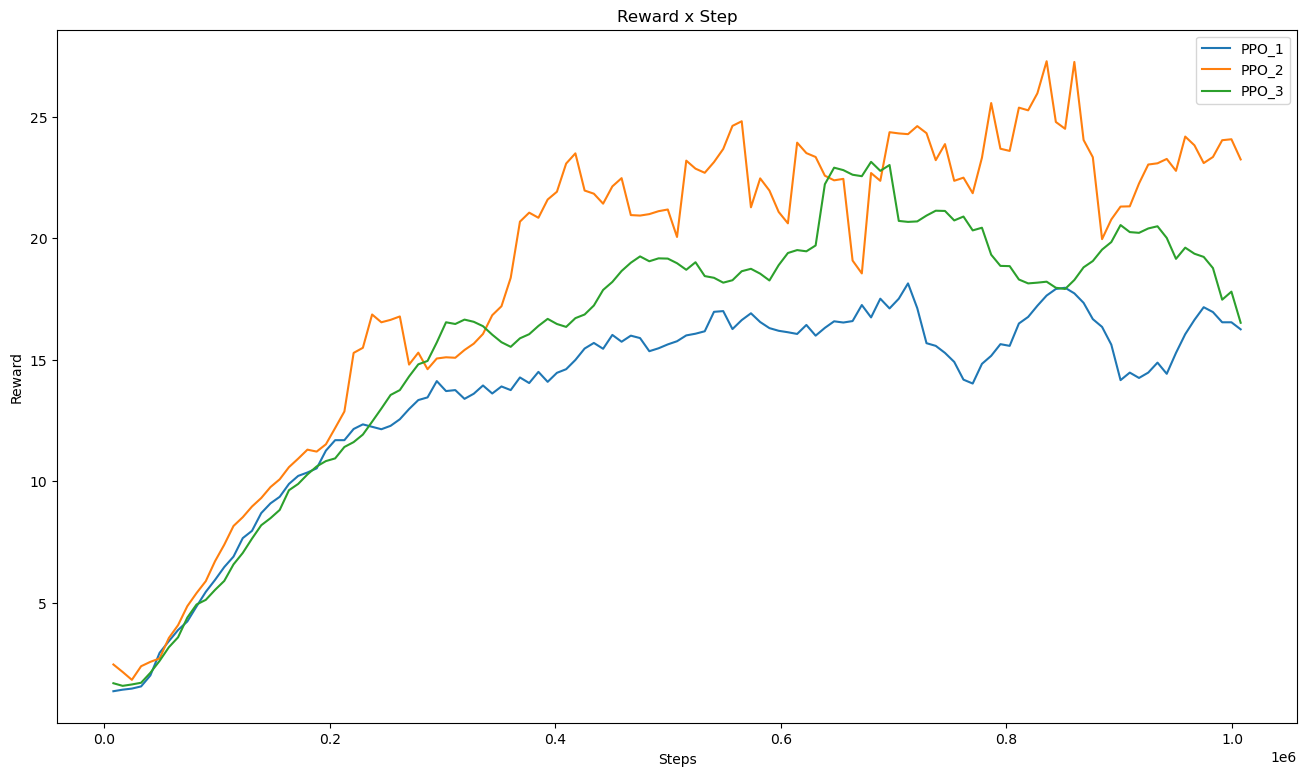

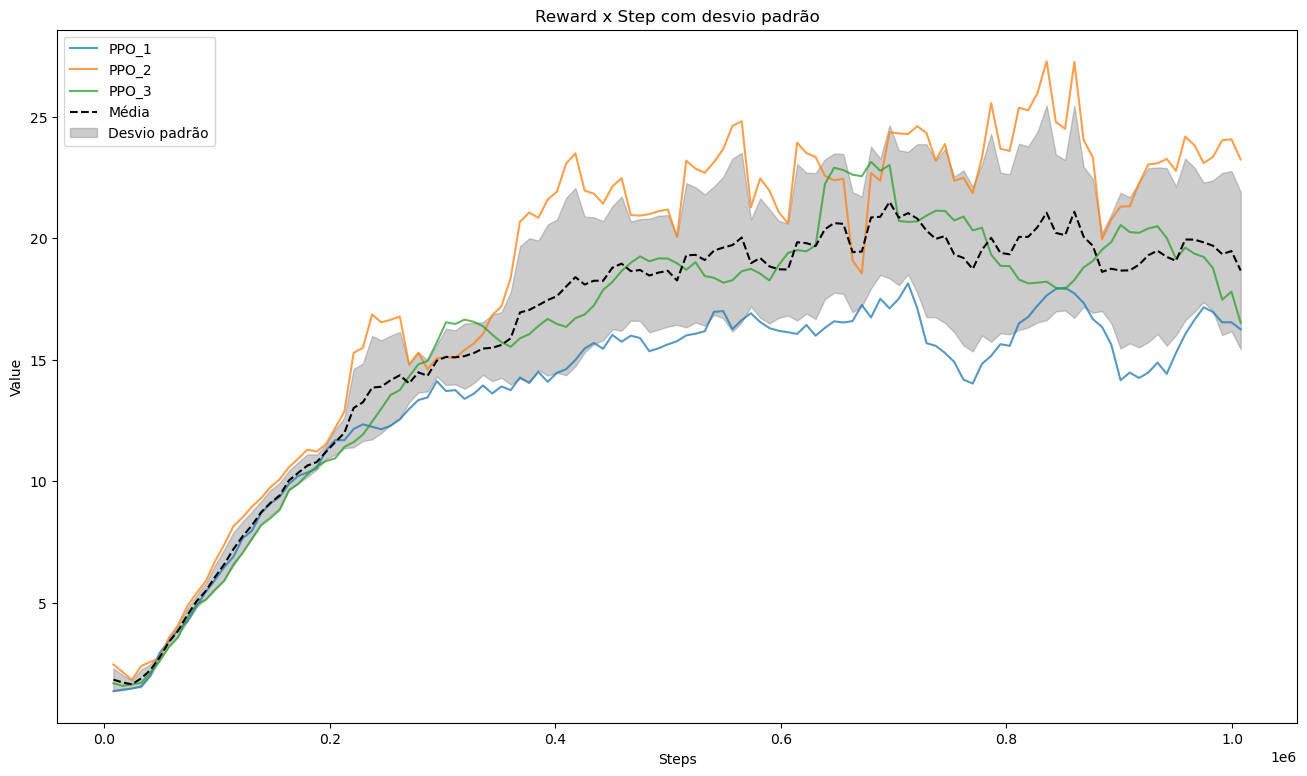

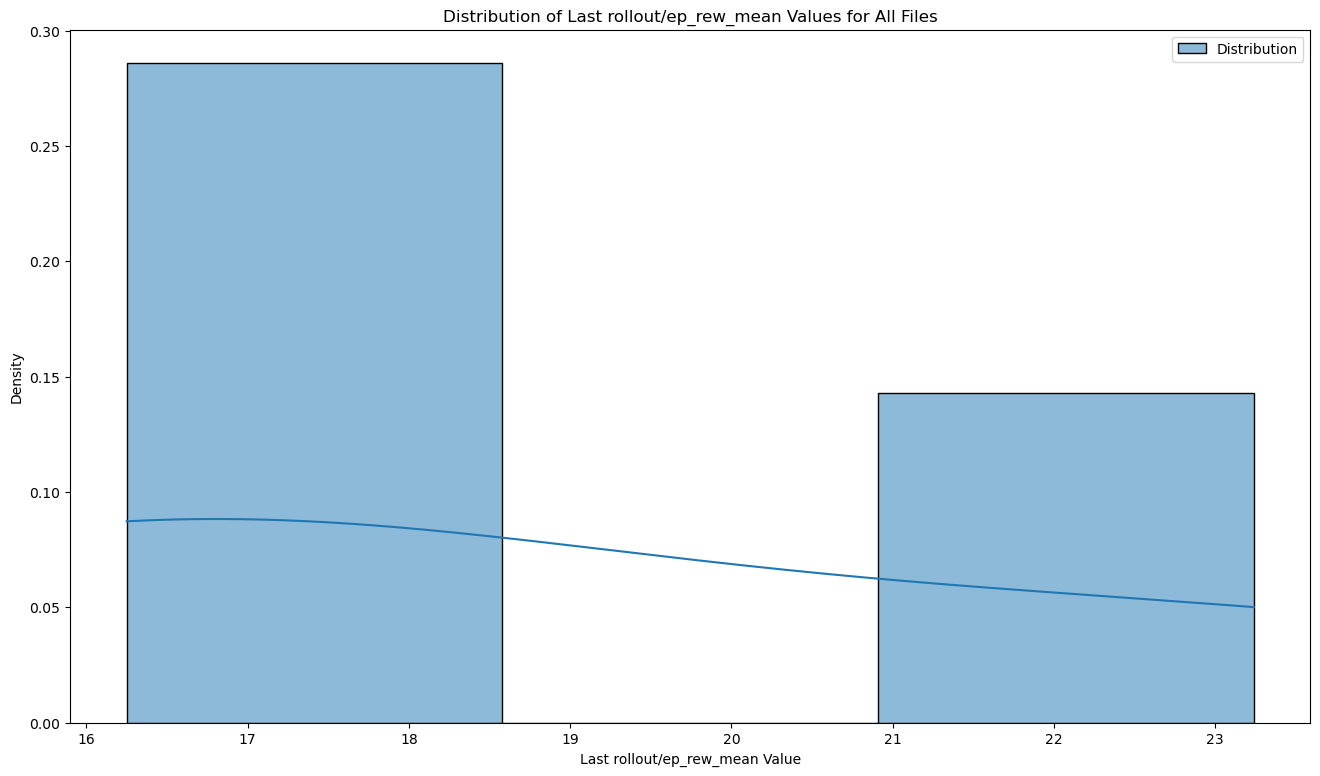

In [39]:
plot_individual(['./ppo_run/'])
plot_individual_and_mean_with_std_and_distribution('./ppo_run/')
plot_distribution_of_last_values('./ppo_run/')

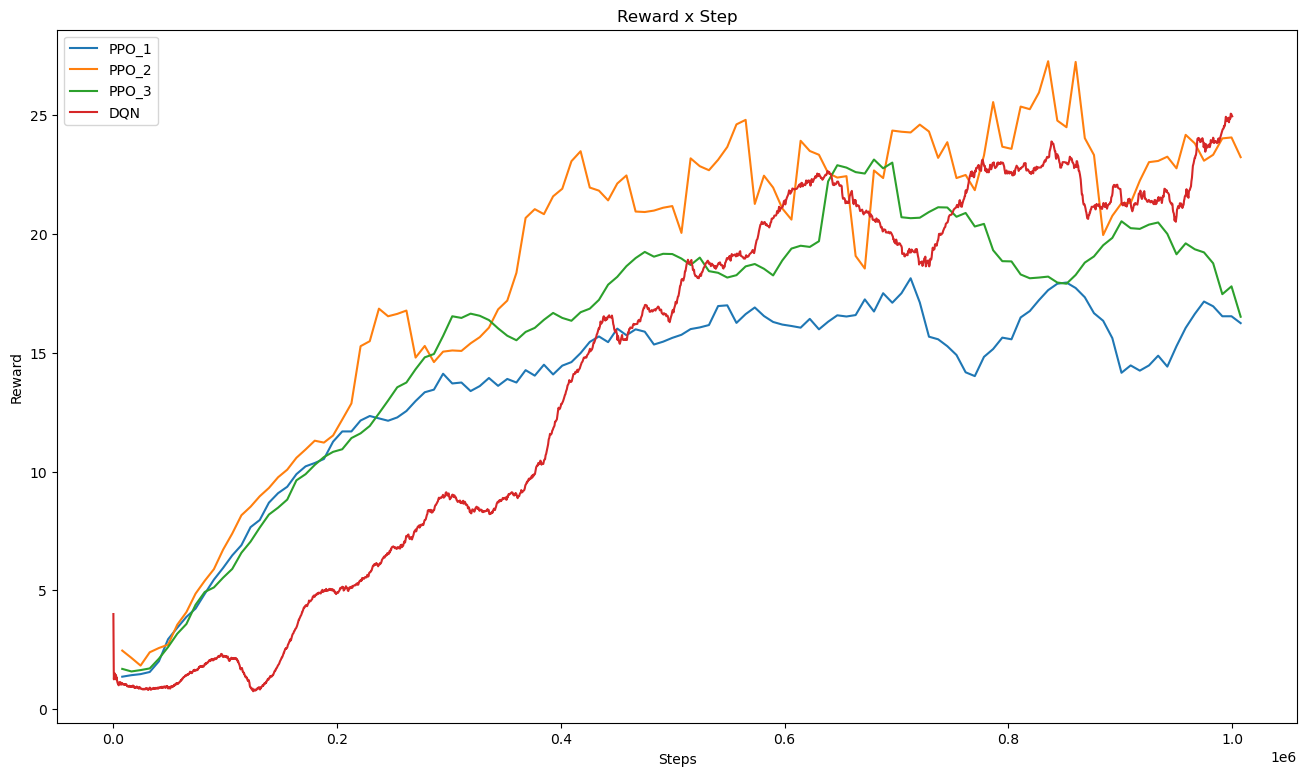

In [40]:
log_directories = ['./ppo_run/', './runs/']
plot_individual(log_directories)

In [ ]:
%tensorboard runs:ppo_run